In [24]:
# Section must be included at the beginning of each new notebook. Remember to change the app name. 
# If you're using VirtualBox, change the below to '/home/user/spark-2.1.1-bin-hadoop2.7'
import findspark
findspark.init('/opt/spark')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('basics').getOrCreate()

In [25]:
# Let's read in the data. If you open the dataset, you'll find that each column has a header. We specify that by stating that header=True.
# To make our lives easier, we can also use 'inferSchema' when importing CSVs. This automatically detects data types.
# If you would like to manually change data types, refer to this article: https://medium.com/@mrpowers/adding-structtype-columns-to-spark-dataframes-b44125409803
df = spark.read.csv('Datasets/aggreated_data.csv',header=True,inferSchema=True)

In [26]:
df = df.na.drop()

# df = df.na.drop(subset="road_surface_conditions")
# df = df.na.drop(subset="light_conditions")
# df = df.na.drop(subset="weather_conditions")
# df = df.na.drop(subset="accident_severity")
# df = df.na.drop(subset="day_of_week")

# df = df.na.drop(subset="special_conditions_at_site")
# df = df.na.drop(subset="pedestrian_movement")
df = df.na.drop(subset="age_of_vehicle")
df = df.na.drop(subset="sex_of_driver")
df = df.na.drop(subset="age_of_driver")
df = df.na.drop(subset="junction_location")
df = df.na.drop(subset="junction_detail")
df = df.na.drop(subset="junction_control")
df = df.na.drop(subset="day_of_week")
df = df.na.drop(subset="accident_severity")



print("Total data points2:", df.count())

Total data points2: 285331


In [27]:
features = [
          'age_of_vehicle','sex_of_driver','age_of_driver','junction_location','junction_detail','junction_control','day_of_week','accident_severity']
# features_s = ['light_conditions','weather_conditions']


df1 = df.select(*features)
df1 = df1.filter(df1.accident_severity > 1)
df1 = df1.filter(df1.age_of_vehicle > 0)
df1 = df1.filter(df1.junction_control > 0)




In [28]:

df2 = df1.filter(df1.accident_severity == 2)
print(df2.count())


13862


In [6]:
df3 = df1.filter(df1.accident_severity == 3)


In [7]:
from numpy.random import randint
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
 
RATIO_ADJUST = 2.0 ## ratio of pos to neg in the df_subsample
 
counts = df1.select('accident_severity').groupBy('accident_severity').count().collect()


higherBound = counts[0][1]

TRESHOLD_TO_FILTER = int(RATIO_ADJUST * float(counts[1][1]) / counts[0][1] * higherBound)


randGen = lambda x: randint(0, higherBound) if x != '3' else -1
 
udfRandGen = udf(randGen, IntegerType())
df1 = df1.withColumn("randIndex", udfRandGen("accident_severity"))



df1 = df1.filter(df1['randIndex'] > TRESHOLD_TO_FILTER)


#print("Before down-sample data ammount", df1.count())
#print("After down-sample data ammount", df_subsample.count())
#print("Distribution of 3 and 2 cases of the down-sampled training data are: \n", df_subsample.groupBy("accident_severity").count().take(3))
#df1 = df_subsample.drop('randIndex')



In [12]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
# categoricalColumns = ['road_surface_conditions','light_conditions','weather_conditions']

ageofvehicle_indexer = StringIndexer(inputCol='age_of_vehicle',outputCol='ageofvehicleIndexer').setHandleInvalid("skip")
sexofdriver_indexer = StringIndexer(inputCol='sex_of_driver',outputCol='sexofdriverIndexer').setHandleInvalid("skip")
ageofdriver_indexer = StringIndexer(inputCol='age_of_driver',outputCol='ageofdriverIndexer').setHandleInvalid("skip")
junctionlocation_indexer = StringIndexer(inputCol='junction_location',outputCol='junctionlocationIndexer').setHandleInvalid("skip")
junctiondetail_indexer = StringIndexer(inputCol='junction_detail',outputCol='junctiondetailIndexer').setHandleInvalid("skip")
junctioncontrol_indexer = StringIndexer(inputCol='junction_control',outputCol='junctioncontrolIndexer').setHandleInvalid("skip")
dayofweek_indexer = StringIndexer(inputCol='day_of_week',outputCol='dayofweekIndexer').setHandleInvalid("skip")


accidentSeverity_indexer = StringIndexer(inputCol='accident_severity',outputCol='label')


# road_surface_conditions_encoder = OneHotEncoder(inputCol='road_surface_conditions_indexer',outputCol='road_surface_conditionsVec')
ageofvehicle_encoder = OneHotEncoder(inputCol='ageofvehicleIndexer',outputCol='ageofvehicleVec')
sexofdriver_encoder = OneHotEncoder(inputCol='sexofdriverIndexer',outputCol='sexofdriverVec')
ageofdriver_encoder = OneHotEncoder(inputCol='ageofdriverIndexer',outputCol='ageofdriverVec')
junctionlocation_encoder = OneHotEncoder(inputCol='junctionlocationIndexer',outputCol='junctionlocationVec')
junctiondetail_encoder = OneHotEncoder(inputCol='junctiondetailIndexer',outputCol='junctiondetailVec')
junctioncontrol_encoder = OneHotEncoder(inputCol='junctioncontrolIndexer',outputCol='junctioncontrolVec')
dayofweek_encoder = OneHotEncoder(inputCol='dayofweekIndexer',outputCol='dayofweekVec')


# And finally, using vector assembler to turn all of these columns into one column (named features).
assembler = VectorAssembler(inputCols=['ageofvehicleVec','sexofdriverVec','ageofdriverVec','junctionlocationVec','junctiondetailVec','junctioncontrolVec','dayofweekVec'], outputCol="features")

In [13]:
from pyspark.ml import Pipeline

# Then go through our steps. It's essentially sequential to the above.
pipeline = Pipeline(stages=[ageofvehicle_indexer, sexofdriver_indexer, ageofdriver_indexer,junctionlocation_indexer,junctiondetail_indexer,junctioncontrol_indexer,dayofweek_indexer,
                            accidentSeverity_indexer,
                            ageofvehicle_encoder, sexofdriver_encoder,ageofdriver_encoder,junctionlocation_encoder,junctiondetail_encoder,junctioncontrol_encoder,dayofweek_encoder,
                            assembler])

# Now that we've got a number of steps, let's apply it to the DataFrame.
pipeline_model = pipeline.fit(df1)

# Incorporate results into a new DataFrame.
pipe_df = pipeline_model.transform(df1)

# Remove all variables other than features and label. 
pipe_df = pipe_df.select('label', 'features')

In [14]:
pipe_df.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(173,[5,62,84,147...|
|  0.0|(173,[0,63,67,147...|
|  0.0|(173,[1,63,74,149...|
|  0.0|(173,[4,62,83,149...|
|  0.0|(173,[9,63,96,148...|
|  0.0|(173,[0,63,89,147...|
|  0.0|(173,[0,63,69,147...|
|  0.0|(173,[1,62,99,148...|
|  0.0|(173,[1,63,103,14...|
|  0.0|(173,[9,62,79,147...|
|  0.0|(173,[1,62,146,14...|
|  0.0|(173,[8,63,83,147...|
|  0.0|(173,[1,63,116,14...|
|  0.0|(173,[6,63,74,150...|
|  0.0|(173,[4,62,79,149...|
|  0.0|(173,[10,63,87,14...|
|  0.0|(173,[11,62,78,14...|
|  0.0|(173,[0,63,78,151...|
|  0.0|(173,[11,63,82,15...|
|  0.0|(173,[9,62,107,14...|
+-----+--------------------+
only showing top 20 rows



In [15]:
from pyspark.ml.classification import LogisticRegression

# Split our data. Note that the new DataFrame is being used.
train_data, test_data = pipe_df.randomSplit([0.7,0.3])
#print("Training Dataset Count: " + str(train_data.count()))
#print("Test Dataset Count: " + str(test_data.count()))

# Instantiate the model.
lr_model = LogisticRegression(featuresCol='features',labelCol='label')

# Fit the model.
lr_model = lr_model.fit(train_data)

# And evaluate the model using the test data.
results = lr_model.transform(test_data)

In [16]:
df1.printSchema()

root
 |-- age_of_vehicle: integer (nullable = true)
 |-- sex_of_driver: integer (nullable = true)
 |-- age_of_driver: integer (nullable = true)
 |-- junction_location: integer (nullable = true)
 |-- junction_detail: integer (nullable = true)
 |-- junction_control: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- accident_severity: integer (nullable = true)
 |-- randIndex: integer (nullable = true)



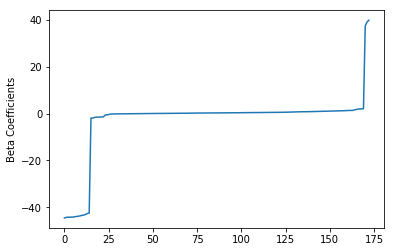

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Visualising the coefficients. Sort from lowest to highest.
beta = np.sort(lr_model.coefficients)

# Plot the data.
plt.plot(beta)

# Add a label to the data.
plt.ylabel('Beta Coefficients')

# Show the graph. 
plt.show()

In [19]:
# Let's get a summary of the data.
training_summary = lr_model.summary



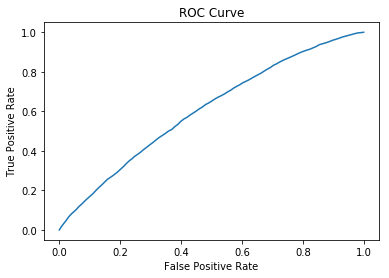

Area Under the Curve: 0.6057744621053741


In [20]:
ROC = training_summary.roc.toPandas()
plt.plot(ROC['FPR'],ROC['TPR'])
# Define the labels.
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Area Under the Curve: ' + str(training_summary.areaUnderROC))

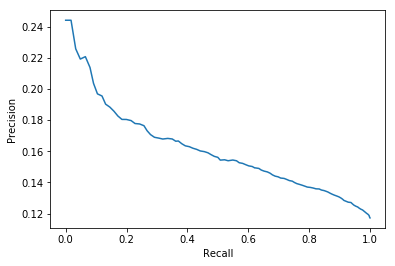

In [21]:
pr = training_summary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [22]:
predictions = lr_model.transform(test_data)
predictions.show()

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  0.0|(173,[0,62,65,147...|[2.48954497853783...|[0.92340562623740...|       0.0|
|  0.0|(173,[0,62,65,147...|[2.48954497853783...|[0.92340562623740...|       0.0|
|  0.0|(173,[0,62,65,147...|[2.58483810036546...|[0.92987938805615...|       0.0|
|  0.0|(173,[0,62,65,147...|[2.55237886756719...|[0.92773316661401...|       0.0|
|  0.0|(173,[0,62,65,147...|[2.52895428208619...|[0.92614685935671...|       0.0|
|  0.0|(173,[0,62,65,147...|[2.89788989374575...|[0.94774202821073...|       0.0|
|  0.0|(173,[0,62,65,147...|[2.85674166059169...|[0.94566612338935...|       0.0|
|  0.0|(173,[0,62,65,147...|[2.95203478241931...|[0.95035956987577...|       0.0|
|  0.0|(173,[0,62,65,147...|[2.88544783757401...|[0.94712236550433...|       0.0|
|  0.0|(173,[0,6

In [23]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', training_summary.areaUnderROC)


Test Area Under ROC 0.6057744621053741
